In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from src import Spotify

spotify = Spotify()

In [2]:
import pandas as pd
import numpy as np
import random as ran
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances as euc

matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 수집

In [6]:
spotify.search_tracks
spotify.get_genres
spotify.genres
spotify.get_features()

spotify.get_reco_tracks
spotify.get_features(target="reco")

계속하시려면 next, 종료는 exit를 입력해주세요.exit


# 데이터 전처리

## 데이터 병합

In [14]:
my_features = spotify.features
reco_features = spotify.reco_features
merge_features = pd.concat([my_features, reco_features])

merge_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2y4hHM6c48Qzk0bqh33XfB,0.539,0.237,0,-8.452,0.0273,0.820,0.000000,0.3450,0.259,68.045
1,1OQ3PoRZRtE7RH0NIh3p1O,0.359,0.469,7,-8.060,0.0326,0.745,0.000000,0.1010,0.259,84.366
0,1cayXr914ctuYeJkv3CPUR,0.677,0.376,0,-9.033,0.0350,0.941,0.000009,0.1770,0.318,83.001
1,6Hmuq21MrWjgAbJKH4gcu8,0.658,0.617,5,-8.507,0.3790,0.351,0.000000,0.3500,0.949,103.734
2,4rwqrKdwlFWJ6LvPYaOtgn,0.440,0.413,0,-7.365,0.0407,0.105,0.000034,0.0997,0.141,86.911


## 정규화

In [15]:
feature_cols = merge_features.columns[1:]

for feature in feature_cols:
    merge_features[feature] = (merge_features[feature] - merge_features[feature].min()) / \
                    (merge_features[feature].max() - merge_features[feature].min() )
    
merge_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2y4hHM6c48Qzk0bqh33XfB,0.447407,0.070064,0.000000,0.465182,0.005959,0.852570,0.000000,0.436388,0.185360,0.036434
1,1OQ3PoRZRtE7RH0NIh3p1O,0.180741,0.439490,0.636364,0.509281,0.018107,0.773589,0.000000,0.071610,0.185360,0.152234
0,1cayXr914ctuYeJkv3CPUR,0.651852,0.291401,0.000000,0.399820,0.023608,0.979992,0.000026,0.185229,0.255018,0.142549
1,6Hmuq21MrWjgAbJKH4gcu8,0.623704,0.675159,0.454545,0.458994,0.812056,0.358677,0.000000,0.443863,1.000000,0.289653
2,4rwqrKdwlFWJ6LvPYaOtgn,0.300741,0.350318,0.000000,0.587468,0.036672,0.099621,0.000092,0.069667,0.046045,0.170291


# 클러스터 개수 선정

In [24]:
K = round(
    mt.sqrt(len(merge_features) / 2)
)
plot_r, plot_c = 1 * mt.ceil(K / 4), 4
print(K)

9


# 무작위 초기 K 선정

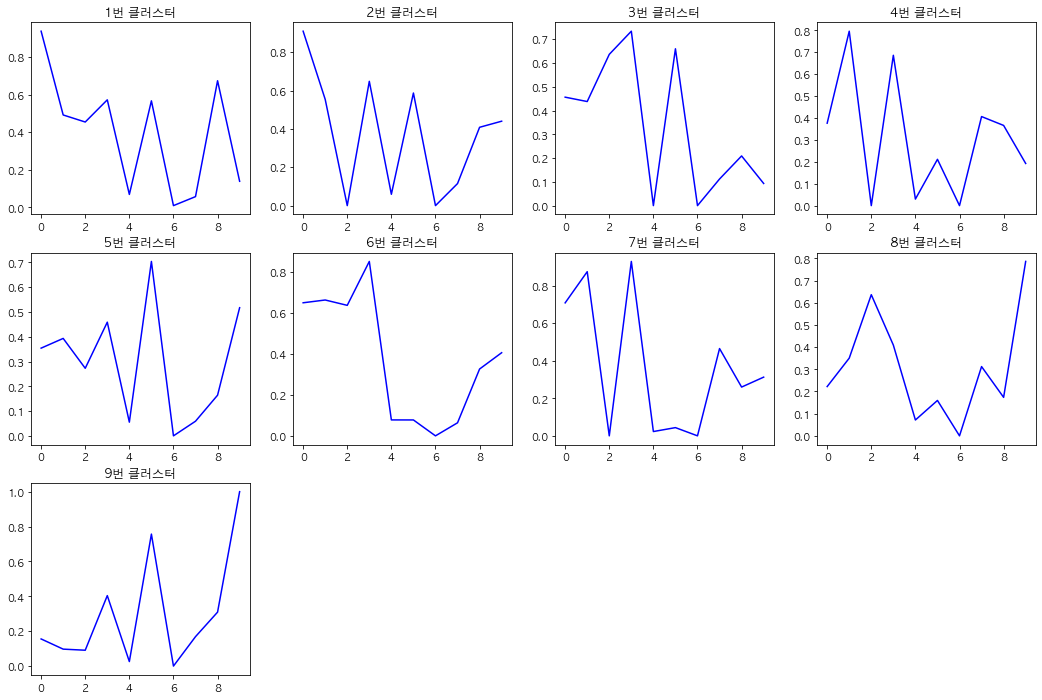

In [40]:
init_K = np.array([])
datas_count = len(merge_features)

while len(init_K) < K:
    _K = ran.randrange(0, datas_count)

    if (_K not in init_K):
        init_K = np.append(init_K, _K)

K_features = merge_features.loc[init_K].values[:,1:]

plt.figure(figsize=(18,12))
for idx,_K_features in enumerate(K_features):
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(_K_features, color='b')
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()

# Cluster Label 부여

In [106]:
features = merge_features.values[:, 1:]
euc_check = euc(features, K_features)
labels = np.array([])

for _euc_check in euc_check:
    labels = np.append(labels,_euc_check.argmin())
    
label_df = pd.DataFrame()
label_df['id'] = merge_features['id']
label_df['label'] = labels.astype("int")
label_df.reset_index(inplace=True)
label_df.drop("index", inplace=True, axis=1)

label_df.head()

,id,label
0,2y4hHM6c48Qzk0bqh33XfB,4
1,1OQ3PoRZRtE7RH0NIh3p1O,2
2,1cayXr914ctuYeJkv3CPUR,4
3,6Hmuq21MrWjgAbJKH4gcu8,0
4,4rwqrKdwlFWJ6LvPYaOtgn,3


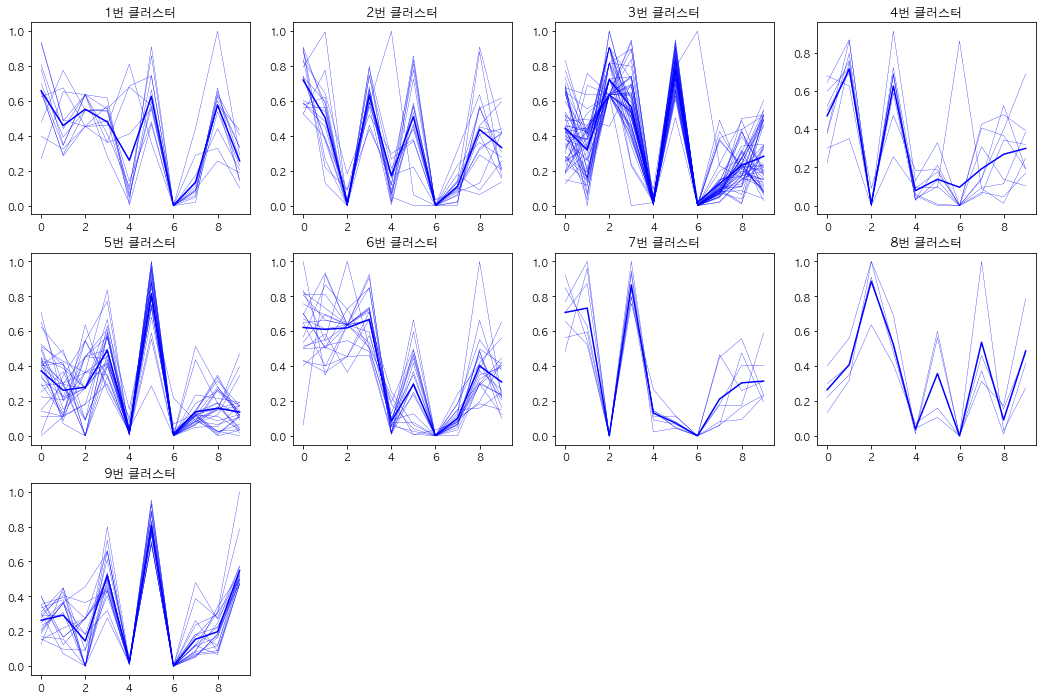

In [107]:
plt.figure(figsize=(18,12))
for idx,_K_features in enumerate(K_features):
    ids = label_df[label_df['label'] == idx].index
    in_features = merge_features.iloc[ids].T.values[1:]
    
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(_K_features, color='b')
    ax.plot(in_features, color='b', linewidth=0.3)
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()

# 중심값 이동

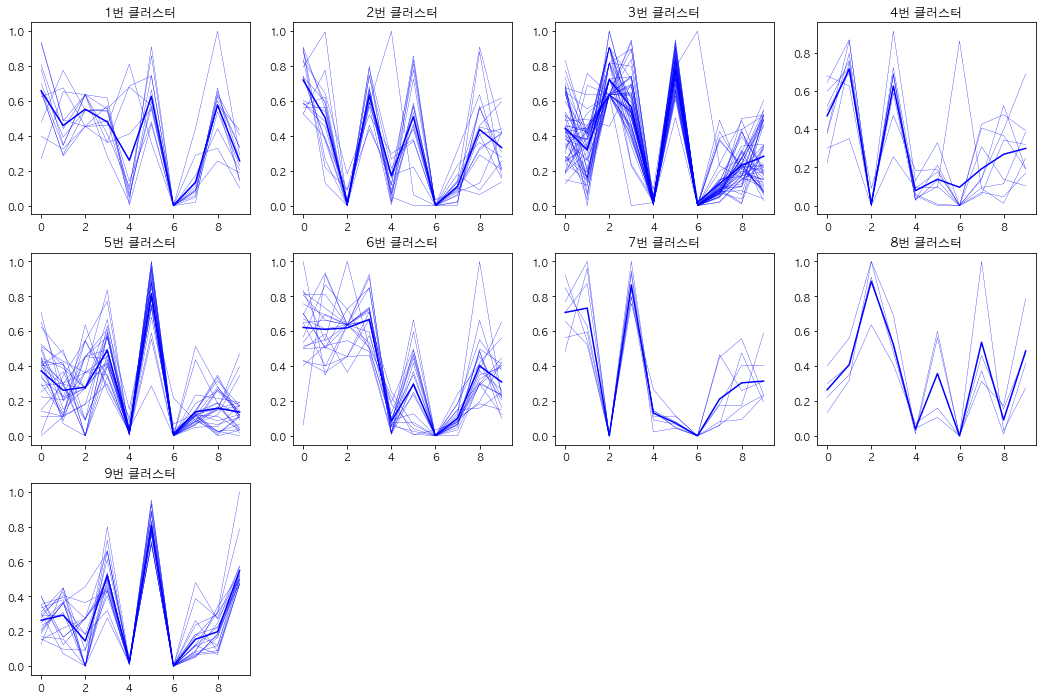

In [108]:
plt.figure(figsize=(18,12))
for idx,_ in enumerate(K_features):
    ids = label_df[label_df['label'] == idx].index
    in_features = merge_features.iloc[ids].values[:,1:]
    
    K_features[idx] = in_features.mean(axis=0)
    
    in_features = merge_features.iloc[ids].T.values[1:]
    
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(K_features[idx], color='b')
    ax.plot(in_features, color='b', linewidth=0.3)
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()

# 품질평가

In [109]:
mean_features = np.expand_dims(merge_features.values[:,1:].mean(axis=0), axis=0)
tss = (euc(mean_features, merge_features.values[:,1:]) ** 2).sum()

tss

71.35808672060074

In [110]:
wss = 0

for idx, _ in enumerate(K_features):
    ids = label_df[label_df['label'] == idx].index
    in_features = merge_features.iloc[ids].values[:,1:]
    
    _K_features = np.expand_dims(_, axis=0)
    wss += (euc(_K_features, in_features) ** 2).sum()
    
wss

32.03023063592893

In [111]:
ecv = 1 - (wss/tss)

ecv

0.5511338362904571

# 음악 필터링 결과

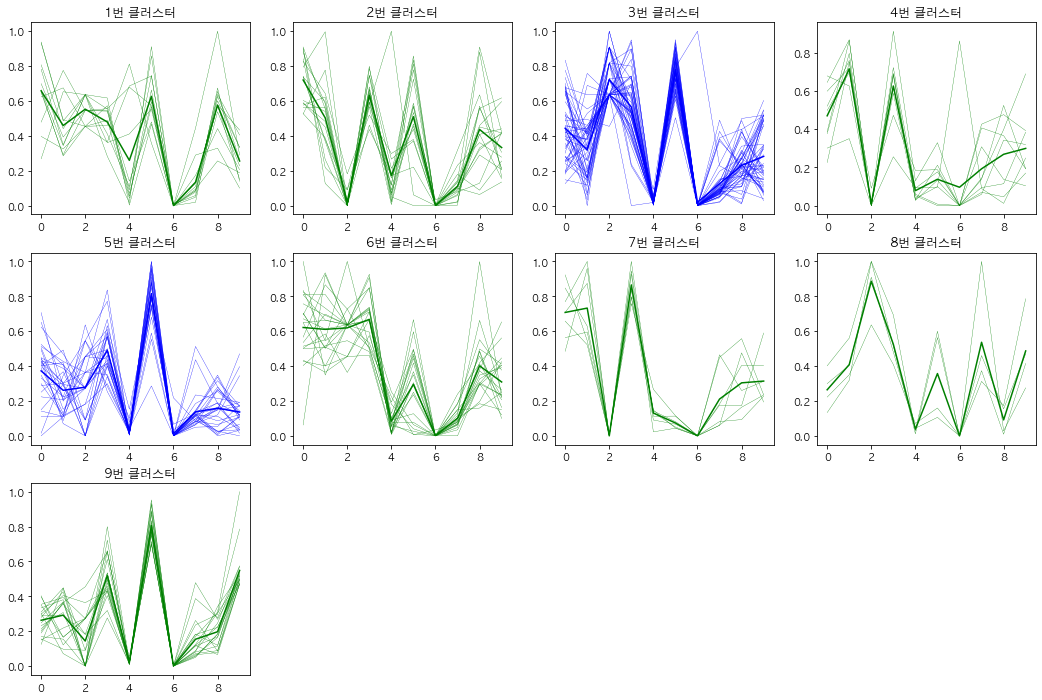

In [206]:
plt.figure(figsize=(18,12))
for idx,_ in enumerate(K_features):
    c = 'g'
    ids = label_df[label_df['label'] == idx].index
    in_features = merge_features.iloc[ids].values[:,1:]
    in_ids = merge_features.iloc[ids]['id'].values
    
    for _id in in_ids:
        if _id in spotify.sel_tracks['id'].values:
            c='b'
            break;
    
    K_features[idx] = in_features.mean(axis=0)
    
    in_features = merge_features.iloc[ids].T.values[1:]
    
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(K_features[idx], color=c)
    ax.plot(in_features, color=c, linewidth=0.3)
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()

## 필터링 전

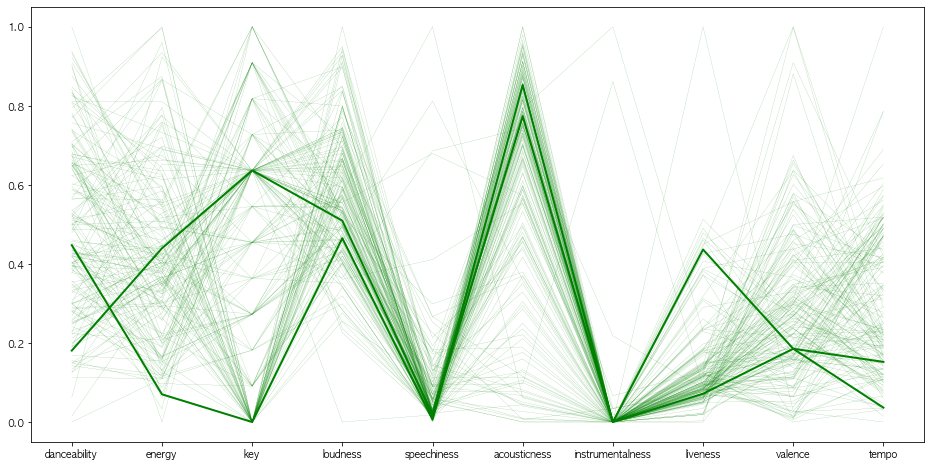

In [188]:
plt.figure(figsize=(16,8))

_merge_features = merge_features.set_index("id")
plt.plot(_merge_features.columns,
         _merge_features.loc[spotify.sel_tracks['id'].values].T.values,
         linewidth=2.0, c='g', label="사용자의 우체통에 등록된 음악")
plt.plot(_merge_features.columns,
        _merge_features.loc[spotify.reco_tracks['id'].values].T.values,
         linewidth=0.1, c='g', label="Spotify로 부터 추천된 음악")

plt.show()

## 필터링 후

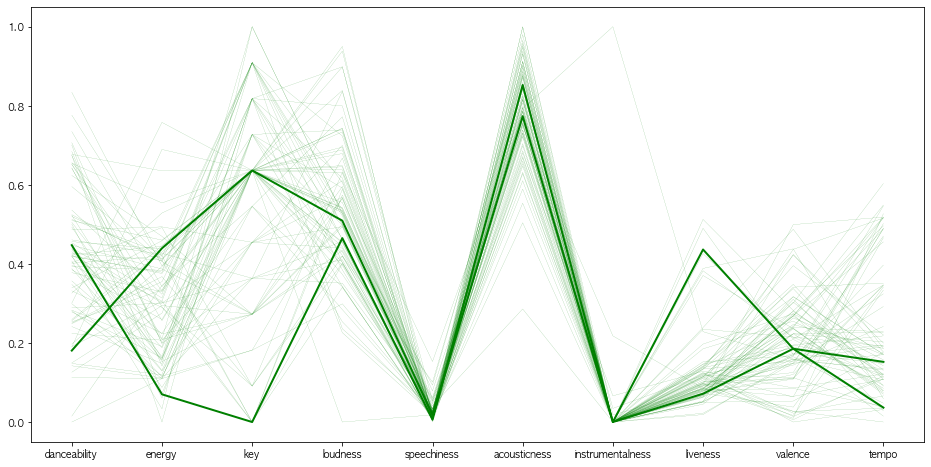

In [189]:
labels = label_df.copy()
labels.set_index("id", inplace=True)

labels = labels.loc[spotify.sel_tracks['id'].values]['label'].values
ids = np.array([])

for label in labels:
    ids = np.append(ids,
                    label_df[label_df['label'] == label]['id'].values)

plt.figure(figsize=(16,8))

_merge_features = merge_features.set_index("id")
plt.plot(_merge_features.columns,
         _merge_features.loc[spotify.sel_tracks['id'].values].T.values,
         linewidth=2.0, c='g', label="사용자의 우체통에 등록된 음악")
plt.plot(_merge_features.columns,
        _merge_features.loc[ids].T.values,
         linewidth=0.1, c='g', label="Spotify로 부터 추천된 음악")

plt.show()